# Human Activity Recognition Using Acceleration Data From Cell Phones

<img src="./images/header_nn_signal.jpg" 
    Width="1200">

## 1. Business Understanding

Human activity recognition (HAR) has applications in a wide range of areas. In healthcare and rehabilitation, HAR can help the activity levels of indivudals and elderly adults, detect falls or identify unusual patterns that may indicate health issues. Within the wearable technology sector, fitness and sports, it can help classify activities to calculate metrics such as calories or sleep quality index. 

This project focuses on HAR using [data](https://www.cis.fordham.edu/wisdm/dataset.php) collected by the Wireless Sensor Data Mining (WISDM) Lab. The dataset includes labeled accelerometer data from 29 users as they perform six different daily activities: walking, jogging, ascending/descending stairs, sitting and standing. The interested reader is referred to [Kwapisz et al., 2010](https://www.cis.fordham.edu/wisdm/includes/files/sensorKDD-2010.pdf) for more information on the methods of data collection and the primary classification methods used. In the original work, 43 features were extracted from the time series data and three classification methods (decision trees, logistic regression and multilayer perceptron) were used to classify the activities. None of the three outperformed the other two in terms of accuracy for all activity categories. However, the multilayer perceptron did the best overall. It was shown that all algorithms struggle to distinguish ascending stairs from descending stairs such that if the two are combined into one one type of activity, the performance of all algorithms improve. 

This work first reproduces the results of [Kwapisz et al., 2010](https://www.cis.fordham.edu/wisdm/includes/files/sensorKDD-2010.pdf) for one of the conventional classification methods they studied. We will then show that we can improve the accuracy of HAR algorithm by using neural networks. 

## 2. Explaratory Data Analysis

In [31]:
%reset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


### Transformed Data with Feature Engineering

Standard classification algorithms (such as logistic regression) cannot be directly used with time-series data such as data collected by accelerometers. Instead, one must first transform the raw time-series data into examples ([Weiss et al., 1998](https://storm.cis.fordham.edu/gweiss/papers/kdd98.pdf)). This is what [Kwapisz et al., 2010](https://www.cis.fordham.edu/wisdm/includes/files/sensorKDD-2010.pdf) did in their original work. Here, we will just reuse the transformed data they prepared for modeling. As mentioned earlier, the authors defined and extracted 43 features based on the raw acceleration data collected (for more information on what these features are, see [Kwapisz et al., 2010](https://www.cis.fordham.edu/wisdm/includes/files/sensorKDD-2010.pdf), p.3).  

In [37]:
with open('./data/WISDM_ar_v1.1_transformed.arff', 'r') as file:
    lines = file.readlines()

col_names = []
for line in lines:
    if line.startswith('@attribute'):
        col_names.append(line.split('"')[1])

In [38]:
col_names[-1] = 'activity'

In [39]:
df = pd.read_csv('./data/WISDM_ar_v1.1_transformed.arff', skiprows=50, header=None, index_col=0, names=col_names)
df.head()

,user,X0,X1,X2,X3,X4,X5,X6,X7,X8,...,YPEAK,ZPEAK,XABSOLDEV,YABSOLDEV,ZABSOLDEV,XSTANDDEV,YSTANDDEV,ZSTANDDEV,RESULTANT,activity
UNIQUE_ID,,,,,,,,,,,,,,,,,,,,,
1,33,0.04,0.09,0.14,0.12,0.11,0.10,0.08,0.13,0.13,...,293.94,1550,3.29,7.21,4.00,4.05,8.17,4.05,11.96,Jogging
2,33,0.12,0.12,0.06,0.07,0.11,0.10,0.11,0.09,0.12,...,269.44,1233.33,4.23,6.88,4.05,5.43,8.19,5.43,12.05,Jogging
3,33,0.14,0.09,0.11,0.09,0.09,0.11,0.12,0.08,0.05,...,248.65,1780,4.18,6.89,4.07,5.55,8.19,5.55,11.99,Jogging
4,33,0.06,0.10,0.09,0.09,0.11,0.07,0.12,0.10,0.14,...,709.09,1380,2.26,4.13,2.49,2.87,4.95,2.87,10.69,Walking
5,33,0.12,0.11,0.10,0.08,0.10,0.14,0.10,0.11,0.08,...,3300,1775,2.29,3.94,2.41,3.08,4.64,3.08,10.80,Walking


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5418 entries, 1 to 386
Data columns (total 45 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user       5418 non-null   int64  
 1   X0         5418 non-null   float64
 2   X1         5418 non-null   float64
 3   X2         5418 non-null   float64
 4   X3         5418 non-null   float64
 5   X4         5418 non-null   float64
 6   X5         5418 non-null   float64
 7   X6         5418 non-null   float64
 8   X7         5418 non-null   float64
 9   X8         5418 non-null   float64
 10  X9         5418 non-null   float64
 11  Y0         5418 non-null   float64
 12  Y1         5418 non-null   float64
 13  Y2         5418 non-null   float64
 14  Y3         5418 non-null   float64
 15  Y4         5418 non-null   float64
 16  Y5         5418 non-null   float64
 17  Y6         5418 non-null   float64
 18  Y7         5418 non-null   float64
 19  Y8         5418 non-null   float64
 20  Y9         541

Although there are no nulls in the data, if we try manipulating the data using standard functions, we will realize that the symbol "?" has been used to represent missing data. 

**Summary:**
- The data has 5418 entries and 43 features. There are no missing data entries.
- *activity* is the target column. 

In [50]:
df_nan = df.replace('?', np.nan).isna().sum()
print('List of tuples representing: feature, # of missing entries:')
# df_nan.index
[(df_nan.index[i], df_nan.iloc[i]) for i in range(0,df_nan.shape[0]) if df_nan.iloc[i]>0]

List of tuples representing: feature, # of missing entries:


[('XPEAK', 381), ('YPEAK', 131), ('ZPEAK', 103)]

In [55]:
print('percentage of missing data:')
(381+131+103)/df.shape[0]*100

percentage of missing data:


12.439320388349515

We will drop all missing entries:

In [53]:
df = df[(df['XPEAK'] != '?') & (df['YPEAK'] != '?') & (df['ZPEAK'] != '?')]

In [61]:
corr_mat = df.iloc[:,1:-1].corr()
features = list(df.columns[1:-1])
high_corr = []
for i,j in zip(range(0,corr_mat.shape[0]), range(0,corr_mat.shape[1])):
    if (corr_mat.iloc[i,j] >= 0.6) & (i != j):
        high_corr.append((features[i], features[j], corr_mat.iloc[i,j]))    

print('List of tuples representing highly-correlated features (corr>=0.6)')
high_corr

List of tuples representing highly-correlated features (corr>=0.6)


[]

### Raw Time-Series Data

The data cannot be read into a pandas data frame directly due to parsing issues. We will first read the data into a file and try to preprocess the data line by line. 

In [10]:
input_file = './data/WISDM_ar_v1.1_raw.txt'
output_file = './data/WISDM_ar_v1.1_raw_clean.txt'

with open(input_file, 'r') as file:
    lines = file.readlines()

clean_lines = []
for line in lines:
        
    # strip the line from trailing whitespace
    line = line.strip()

    if len(line) == 0:
        continue
        
    records = line.split(';')

    if len(records) > 2:
        clean_lines.extend([record.strip()+'\n' for record in records if record.strip()])
    else:
        if records[0][-1] == ",":
            line = records[0][:-1]
        clean_lines.append(line.strip(';') +'\n')

with open(output_file,'w') as file:
    file.writelines(clean_lines)

dft = pd.read_csv(output_file, low_memory=False, header=None, names=["ID", "Activity", "Timestamp", "X", "Y", "Z"])

In [11]:
dft.columns= ['user_id', 'activity', 'time_stamp', 'x', 'y', 'z']

In [12]:
display(dft.head(5))
dft.info()

,user_id,activity,time_stamp,x,y,z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098209 entries, 0 to 1098208
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   user_id     1098209 non-null  int64  
 1   activity    1098209 non-null  object 
 2   time_stamp  1098209 non-null  int64  
 3   x           1098209 non-null  float64
 4   y           1098209 non-null  float64
 5   z           1098208 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 50.3+ MB


Let's see if we have any missing data: 

In [33]:
dft.isna().sum()

user_id       0
activity      0
time_stamp    0
x             0
y             0
z             1
dtype: int64

We only have one missing data in the z acceleration entry. Let's drop this record:

In [34]:
dft.dropna(inplace = True)

In [35]:
df_random_user = dft[dft.user_id == 33].sort_values(by='time_stamp')
df_random_user['time_stamp'] = (df_random_user['time_stamp'] - df_random_user['time_stamp'].min() )/1E9
df_random_user.head()

,user_id,activity,time_stamp,x,y,z
462772,33,Standing,0.000000,0.11,9.89,1.46
462773,33,Standing,0.049927,0.11,9.92,1.46
462774,33,Standing,0.099945,0.08,9.92,1.46
462775,33,Standing,0.149963,0.04,9.89,1.46
462776,33,Standing,0.199981,0.08,9.92,1.46


Text(0, 0.5, 'Acceleration [$m/s^2$]')

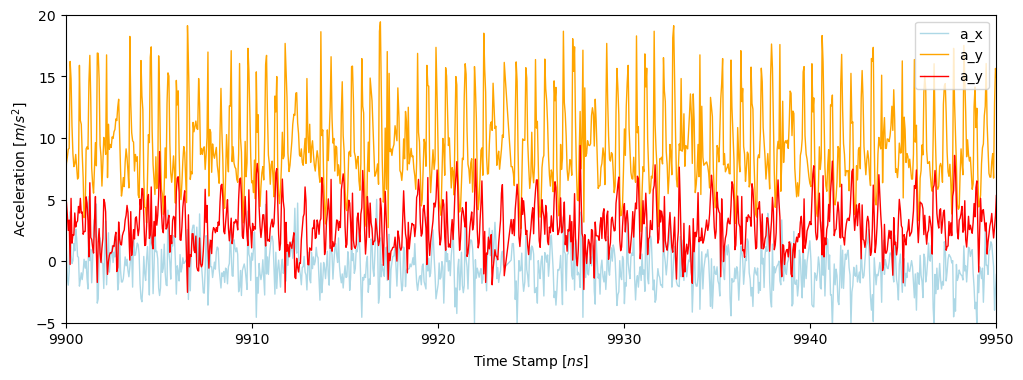

In [36]:
fig, ax = plt.subplots(figsize=(12,4))
df_random_user.plot(x='time_stamp', y='x', ax=ax, label = 'a_x', linewidth=1, color='lightblue')
df_random_user.plot(x='time_stamp', y='y', ax=ax, label = 'a_y', linewidth=1, color='orange')
df_random_user.plot(x='time_stamp', y='z', ax=ax, label = 'a_y', linewidth=1, color='r')

ax.set_xlim(9900,9950)
ax.set_ylim(-5,20)
ax.set_xlabel('Time Stamp [$ns$]')
ax.set_ylabel('Acceleration [$m/s^2$]')

In [37]:
dft['activity'].value_counts(normalize=True)

activity
Walking       0.386447
Jogging       0.311579
Upstairs      0.111881
Downstairs    0.091446
Sitting       0.054579
Standing      0.044067
Name: proportion, dtype: float64

## 3. Machine Learning Model

## 4. Results and Recommendations

## 5. Limitations and Next Steps